# Specially Ordered Sets (SOS)
Specially ordered sets (SOS) are commonly used sets of constraints that can be passed to the solver with easy nontation.  The solver can then decide how to best deal with this type of constraint, as opposed to trying to understand a manually inserted constraint.  This makes modeling easier and makes the solver more efficient.

That said, sometimes it can be better to manually model these constraints if you need to interact with the variables used in the constraints.  

We will demonstrate the different types of SOS constraints that GUROBI has.

# Specially orders sets of type 1 (SOS1)
These constraints are used to model that at most one of a set of variables $x_1, \dots, x_n$ can be non-zero.


Manually, you might model this with a set of binary variables $z_1, \dots, z_n$ 
$$
\begin{array}{c}
0 \leq x_i \leq Mz_i,  \\
\sum_{i=1}^n z_i \leq 1 \\
z_i  \in \{0,1\} \text{ for } i=1, \dots, n
\end{array}
$$
Where $M$ is an upper bound on the variables $x_i$.


Instead, this can be modeled as 
$$
\textrm{SOS1}(x_1, \dots, x_n).
$$
This reduces the need to define the variables $z_i$.  Notice how this improves the readability of the model!


###  We now show how to code this with GUROBI.

In [30]:
from gurobipy import *
# Create a new model
m = Model("SOS1")

# Create set
I = range(4)

# Create variables
x = m.addVars(I, vtype=GRB.CONTINUOUS, name="x", ub = 10)

# Set objective
m.setObjective(2*x[0] + 5*x[1] + 1*x[2] + 7*x[3], GRB.MAXIMIZE)


# Add SOS Constraint (At most on of the x_i is non-zero)
m.addSOS(GRB.SOS_TYPE1, x)

# Optimize model
m.optimize()

print("\n Solution: \n")

for v in m.getVars():
    print('%s %g' % (v.varName, v.x))

print('Obj: %g' % m.objVal)

Gurobi Optimizer version 9.0.3 build v9.0.3rc0 (mac64)
Optimize a model with 0 rows, 4 columns and 0 nonzeros
Model fingerprint: 0x75e07190
Model has 1 SOS constraint
Variable types: 4 continuous, 0 integer (0 binary)
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  Objective range  [1e+00, 7e+00]
  Bounds range     [1e+01, 1e+01]
  RHS range        [0e+00, 0e+00]
Found heuristic solution: objective -0.0000000
Presolve removed 0 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.01 seconds
Thread count was 1 (of 12 available processors)

Solution count 2: 70 

Optimal solution found (tolerance 1.00e-04)
Best objective 7.000000000000e+01, best bound 7.000000000000e+01, gap 0.0000%

 Solution: 

x[0] 0
x[1] 0
x[2] 0
x[3] 10
Obj: 70


## SOS2 Example
Model the piecewise linear function:

<img src="pwl.png" width="300">

In [6]:
from gurobipy import *
# Create a new model
m = Model("SOS-piecewise-linear")

# Create set
I = range(4)

# Create variables
x = m.addVar(name = 'x', lb = 3, ub = 3)
y = m.addVar(name = 'y')
z = m.addVars(I, vtype=GRB.CONTINUOUS, name="z", lb = 0, ub = 1)

# Set objective
m.setObjective(0, GRB.MAXIMIZE)

# Add constraint: 
m.addConstr(x - 5*z[1] - 10*z[2] - 15*z[3] == 0, "c0")

# Add constraint: 
m.addConstr(y - 125*z[1] - 225*z[2] - 300*z[3] == 0, "c1")

m.addConstr(sum(z[i] for i in I) == 1)

# Add SOS Constraint (At most on of the x_i is non-zero)
m.addSOS(GRB.SOS_TYPE2, z, [1,2,3,4])

# Optimize model
m.optimize()

print("\n Solution: \n")

for v in m.getVars():
    print('%s %g' % (v.varName, v.x))

print('Obj: %g' % m.objVal)


Gurobi Optimizer version 9.0.3 build v9.0.3rc0 (mac64)
Optimize a model with 3 rows, 6 columns and 12 nonzeros
Model fingerprint: 0x4ec832a3
Model has 1 SOS constraint
Variable types: 6 continuous, 0 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+02]
  Objective range  [0e+00, 0e+00]
  Bounds range     [1e+00, 3e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 3 rows and 6 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.01 seconds
Thread count was 1 (of 12 available processors)

Solution count 1: -0 
No other solutions better than -0

Optimal solution found (tolerance 1.00e-04)
Best objective -0.000000000000e+00, best bound -0.000000000000e+00, gap 0.0000%

 Solution: 

x 3
y 75
z[0] 0.4
z[1] 0.6
z[2] 0
z[3] 0
Obj: -0


In [12]:

m.write("piecewise.lp")
m.write("piercewise.sol")

# SOS2 Example

$$
\begin{array}{rl}
\min &\sum_{i=1}^5 x_i^3 \sin(x_i) + \cos(x_i)\\
\text{s.t.} &
\sum_{i=1}^5 x_i \leq 1\\
&x_i \geq 0
\end{array}
$$

This problem could be solved with nonlinear programming techniques.  But we can also solve it by approximating the objective function with a piecewise linear function and using integer programming techniques.

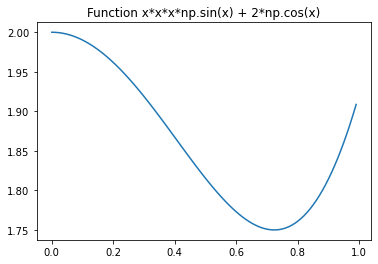

In [3]:
import matplotlib.pyplot as plt
import numpy as np
# Create data
def f(x):
    return x*x*x*np.sin(x) + 2*np.cos(x)



delta = 0.01 # number of breakpoints
X = np.arange(0, 1, delta)
num_breakpoints = len(X)

Y = [f(x) for x in X]
plt.title("Function x*x*x*np.sin(x) + 2*np.cos(x)")
plt.plot(X,Y)


In [16]:
from gurobipy import *



# Create a new model
m = Model("SOS-piecewise-linear")

# Create set
I = range(5) # set of variables
Breakpoints = range(num_breakpoints) # set of breakpoints

# Create variables
x = m.addVars(I, name = 'x', lb = 0, ub = 1) # decision variables
y = m.addVars(I, name = 'y') # y_i = f(x_i)
z = m.addVars(I,Breakpoints, vtype=GRB.CONTINUOUS, name="z", lb = 0, ub = 1)

# Set objective
m.setObjective(sum(y[i] for i in I), GRB.MINIMIZE)


# Constraints for Piecewise Linear Function
## Add constraint: 
m.addConstrs((x[i] == sum(X[b]*z[i,b] for b in Breakpoints) for i in I), "set x values")

## Add constraint: 
m.addConstrs((y[i] == sum(Y[b]*z[i,b] for b in Breakpoints) for i in I), "set x values")

m.addConstrs((sum(z[i,b] for b in Breakpoints) == 1 for i in I), "sum fractios to 1")

## Add SOS Constraint (At most on of the x_i is non-zero)
for i in I:
    m.addSOS(GRB.SOS_TYPE2, [z[i,b] for b in Breakpoints], Breakpoints)

# Other constraints
m.addConstr(sum(i*x[i] for i in I) <= 3)

m.addConstrs(x[i] >= 0.1 for i in I)
    
    
# Optimize model
m.optimize()

print("\n Solution: \n")

for v in m.getVars():
    print('%s %g' % (v.varName, v.x))

print('Obj: %g' % m.objVal)

Gurobi Optimizer version 9.0.3 build v9.0.3rc0 (mac64)
Optimize a model with 21 rows, 510 columns and 1514 nonzeros
Model fingerprint: 0x920d4743
Model has 5 SOS constraints
Variable types: 510 continuous, 0 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e-02, 4e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-01, 3e+00]
Presolve removed 12 rows and 106 columns
Presolve time: 0.00s
Presolved: 9 rows, 404 columns, 804 nonzeros
Presolved model has 4 SOS constraint(s)
Variable types: 404 continuous, 0 integer (0 binary)

Root relaxation: objective 9.144395e+00, 20 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    9.19326    0    2          -    9.19326      -     -    0s
H    0     0                       9.2490337    9.19326  0.60%     -    0s
     0     0    9.19326    0    2    9.24